In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc
import multiprocessing as mp
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

# Load Streamflow Gauge Readings

In [119]:
station_id = 16240500# manoa
df_obs = pd.read_csv(f"{base_dir}/preprocessed_data/selected_flowgauge_15mins/{station_id}.csv")
df_obs['hst_timestamp'] = pd.to_datetime(df_obs['hst_timestamp'])
df_obs['utc_timestamp'] = df_obs['hst_timestamp'].dt.tz_convert('UTC')
df_obs = df_obs.set_index('utc_timestamp').drop(columns=['hst_timestamp'])
df_obs.index = df_obs.index.tz_localize(None)

In [121]:
df_obs_hourly_mean_all = df_obs.resample('h').mean()
df_obs_hourly_mean = df_obs_hourly_mean_all[(df_obs.groupby(pd.Grouper(freq='h')).size() == 4)]
df_3hourly = df_obs_hourly_mean.resample('3h').max()

threshold = 3
num_exceedance = sum(df_3hourly['measurement'] > 3)
print(f"With {threshold=}, there are {num_exceedance} occurences of \"flood\"")
df_obs = df_3hourly # rename for easy typing

With threshold=3, there are 14 occurences of "flood"


# Load ERA5

In [122]:
all_year_data = []
for year in tqdm(range(2007, 2025)):
    all_year_data.append(xr.open_dataset(f"{base_dir}/preprocessed_data/regridded_3hourly_ERA5/{year}.nc"))
concatenated = xr.concat(all_year_data, dim='time')

  6%|█████████▋                                                                                                                                                                     | 1/18 [00:00<00:01,  9.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.82it/s]


In [125]:
extreme_weathers = (concatenated.drop_duplicates(dim='time')
                    .sel(time=df_obs.query(f'measurement >= {threshold}').index)
                    .sel(lon=slice(195, 210), lat=slice(15, 26)))

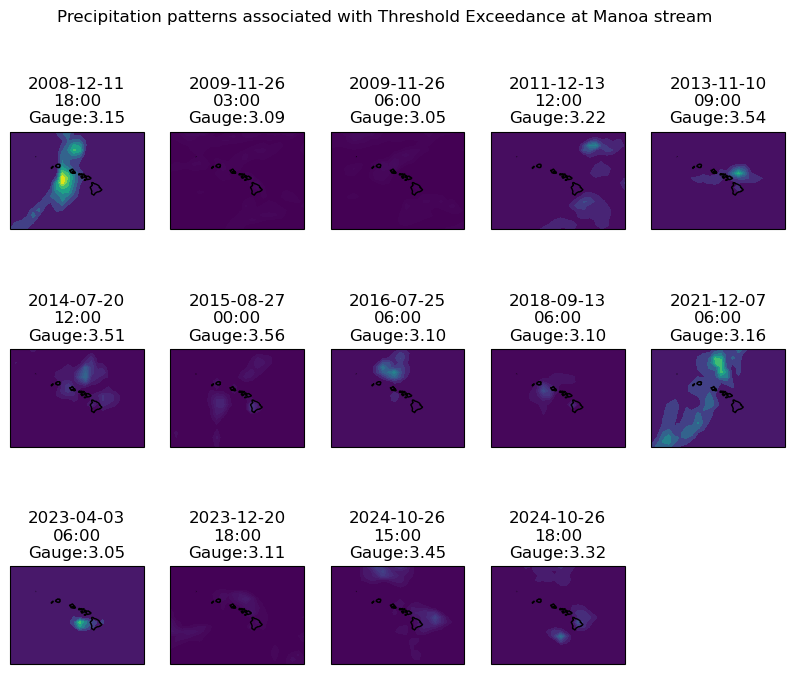

In [262]:
lons, lats = np.meshgrid(extreme_weathers.lon, extreme_weathers.lat)
fig, axs = plt.subplots(3,5, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10,8))
vmin, vmax = extreme_weathers['tp'].min(), extreme_weathers['tp'].max()
fig.delaxes(axs[2,4])
for i, ax in enumerate(axs.flatten()[:-1]):
    individual_weather = extreme_weathers.isel(time=i) # xarray
    gauge = df_obs[df_obs.index == pd.Timestamp(individual_weather.time.values)]['measurement'].values[0] # pandas
    ax.contourf(lons, lats, individual_weather['tp'], vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(pd.Timestamp(individual_weather.time.values).strftime("%Y-%m-%d\n%H:%M") + f"\nGauge:{gauge:.2f}")

fig.suptitle('Precipitation patterns associated with Threshold Exceedance at Manoa stream')
pass

In [263]:
dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]
wet_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(wet_months))['tp'].mean(axis=0)
dry_composite = extreme_weathers.sel(time=extreme_weathers['time'].dt.month.isin(dry_months))['tp'].mean(axis=0)

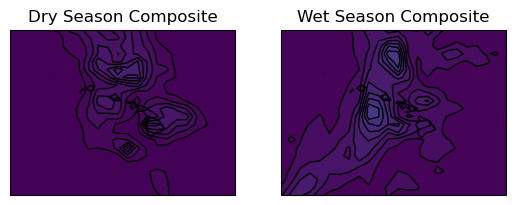

In [264]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, composite in zip(axs.flatten(), [dry_composite, wet_composite]):
    ax.contourf(lons, lats, composite, vmin=vmin, vmax=vmax)
    ax.coastlines()
    cs = ax.contour(lons, lats, composite, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    # add contour labels
    # lb = plt.clabel(cs, fontsize=12, inline=False, fmt='%0.1f');
axs[0].set_title('Dry Season Composite')
axs[1].set_title('Wet Season Composite')
pass

In [ ]:
coors = []
for ind_map in tqdm(concatenated['tp']):
    if ind_map.isnull().all():
        coors.append(np.nan)
        continue
    seasonal_composite = dry_composite if ind_map.time.dt.month.isin(dry_months) else wet_composite
    corr = xr.corr(ind_map, seasonal_composite)
    coors.append(corr.values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52600/52600 [07:32<00:00, 116.25it/s]


In [214]:
df_stats = pd.DataFrame({'ts': concatenated.time, 'r': coors})
df_stats = pd.merge(df_obs, df_stats, left_index=True, right_on='ts')

In [ ]:
df_stats['exceed'] = df_stats['measurement'] > 3

In [237]:
fpr, tpr, thresholds = roc_curve(df_stats.dropna()['exceed'], np.clip(df_stats.dropna()['r'], a_min=0, a_max=None))
roc_auc = auc(fpr, tpr)

In [289]:
df_stats.query('r > 0.6')

,measurement,ts,r,exceed
5686,3.146250,2008-12-11 18:00:00,0.8795379,True
5706,1.237500,2008-12-14 06:00:00,0.6315991,False
7668,0.350000,2009-08-16 12:00:00,0.6221659,False
7685,0.300000,2009-08-18 15:00:00,0.6454506,False
9745,0.422500,2010-05-03 03:00:00,0.6562173,False
12666,1.222500,2011-05-03 06:00:00,0.60927826,False
12926,1.050000,2011-06-04 18:00:00,0.62542725,False
12928,0.530000,2011-06-05 00:00:00,0.6310193,False
19716,0.315000,2013-09-30 12:00:00,0.6468627,False
20216,1.600833,2013-12-02 00:00:00,0.6346527,False


In [288]:
df_stats.query('exceed == True')

,measurement,ts,r,exceed
5686,3.146250,2008-12-11 18:00:00,0.8795379,True
8481,3.087500,2009-11-26 03:00:00,-0.03608604,True
8482,3.047500,2009-11-26 06:00:00,0.092459396,True
14460,3.223333,2011-12-13 12:00:00,-0.11850218,True
20043,3.539167,2013-11-10 09:00:00,0.2553114,True
22060,3.511667,2014-07-20 12:00:00,0.72909415,True
25280,3.562083,2015-08-27 00:00:00,0.29738134,True
27946,3.096667,2016-07-25 06:00:00,0.67196435,True
34186,3.098333,2018-09-13 06:00:00,0.39740878,True
43634,3.164167,2021-12-07 06:00:00,0.75369847,True


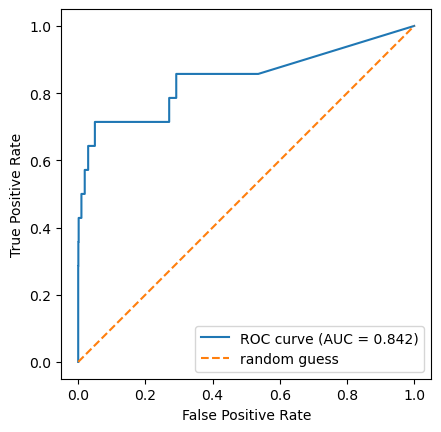

In [250]:
fig, ax = plt.subplots(1)
ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1], [0,1], linestyle='--', label='random guess')
ax.legend()

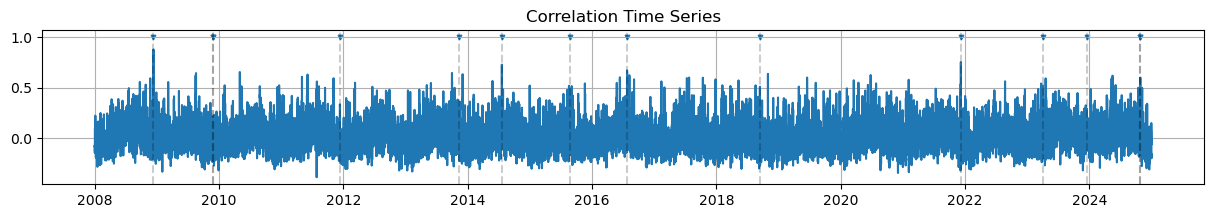

In [286]:
fig, ax = plt.subplots(1, figsize=(15,2))
ax.plot(df_stats['ts'], df_stats['r'])
ax.scatter(df_obs.query('measurement > 3').index, [1 for _ in range(len(df_obs.query('measurement > 3').index))], s=10, marker='v')
for i in df_obs.query('measurement > 3').index:
    ax.axvline(i, linestyle='--', c='k', alpha=0.2)
# ax.axhline(0.6, linestyle='--', c='orange')
ax.set_title('Correlation Time Series')
ax.grid()